# Using Pandas instead of Turi Create as it is not supported in Windows

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

# Load some house value vs. crime rate data

Dataset is from Philadelphia, PA and includes average house sales price in a number of neighborhoods.  The attributes of each neighborhood we have include the crime rate ('CrimeRate'), miles from Center City ('MilesPhila'), town name ('Name'), and county name ('County').

In [2]:
sales = pd.read_csv('https://courses.cs.washington.edu/courses/cse416/18sp/notebooks/Philadelphia_Crime_Rate_noNA.csv')

In [3]:
sales

,HousePrice,"HsPrc ($10,000)",CrimeRate,MilesPhila,PopChg,Name,County
0,140463,14.0463,29.7,10.0,-1.0,Abington,Montgome
1,113033,11.3033,24.1,18.0,4.0,Ambler,Montgome
2,124186,12.4186,19.5,25.0,8.0,Aston,Delaware
3,110490,11.0490,49.4,25.0,2.7,Bensalem,Bucks
4,79124,7.9124,54.1,19.0,3.9,Bristol B.,Bucks
...,...,...,...,...,...,...,...
94,174232,17.4232,13.8,25.0,4.7,Westtown,Chester
95,196515,19.6515,29.9,16.0,1.8,Whitemarsh,Montgome
96,232714,23.2714,9.9,21.0,0.2,Willistown,Chester
97,245920,24.5920,22.6,10.0,0.3,Wynnewood,Montgome


# Exploring the data 

The house price in a town is correlated with the crime rate of that town. Low crime towns tend to be associated with higher house prices and vice versa.

<function matplotlib.pyplot.show(*args, **kw)>

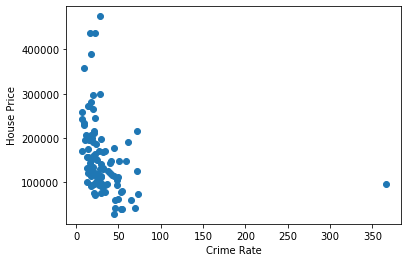

In [4]:
plt.scatter(sales['CrimeRate'], sales['HousePrice'])
plt.xlabel('Crime Rate')
plt.ylabel('House Price')
plt.show

#turicreate.show(sales["CrimeRate"], sales["HousePrice"])

# Fit the regression model using crime as the feature

In [5]:
X = np.array(sales['CrimeRate'])
X = X.reshape(-1,1)
y = np.array(sales['HousePrice'])

reg = LinearRegression()
crime_model = reg.fit(X,y)

#crime_model = turicreate.linear_regression.create(
#    sales,
#    target="HousePrice",
#    features=['CrimeRate'],
#    validation_set=None,
#    verbose=False
#)

# Let's see what our fit looks like

Matplotlib is a Python plotting library that is also useful for plotting.  You can install it with:

'pip install matplotlib'

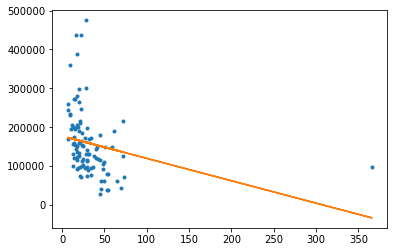

In [6]:
plt.plot(sales['CrimeRate'],sales['HousePrice'],'.',
        sales['CrimeRate'],crime_model.predict(np.array(X)),'-')

Above: blue dots are original data, orange line is the fit from the simple regression.

# Remove Center City and redo the analysis

Center City is the one observation with an extremely high crime rate, yet house prices are not very low.  This point does not follow the trend of the rest of the data very well.  A question is how much including Center City is influencing our fit on the other datapoints.  Let's remove this datapoint and see what happens.

In [7]:
sales_noCC = sales[sales['MilesPhila'] != 0.0]

<function matplotlib.pyplot.show(*args, **kw)>

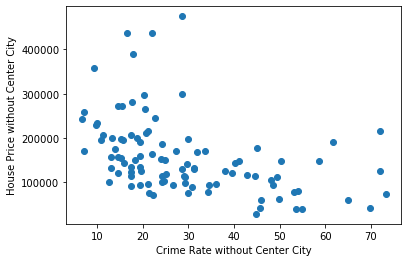

In [8]:
plt.scatter(sales_noCC['CrimeRate'], sales_noCC['HousePrice'])
plt.xlabel('Crime Rate without Center City')
plt.ylabel('House Price without Center City')
plt.show

#turicreate.show(sales["CrimeRate"], sales["HousePrice"])

### Refit our simple regression model on this modified dataset:

In [9]:
X_noCC = np.array(sales_noCC['CrimeRate'])
X_noCC = X_noCC.reshape(-1,1)
y_noCC = np.array(sales_noCC['HousePrice'])

reg_noCC = LinearRegression()
crime_model_noCC = reg_noCC.fit(X_noCC,y_noCC)


#crime_model_noCC = turicreate.linear_regression.create(
#    sales_noCC,
#    target='HousePrice',
#    features=['CrimeRate'],
#    validation_set = None,
#    verbose = False
#)

### Look at the fit:

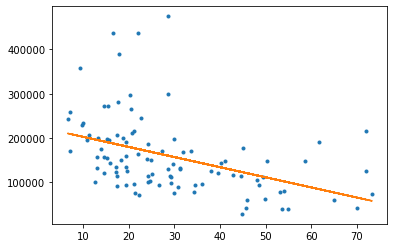

In [10]:
plt.plot(sales_noCC['CrimeRate'], sales_noCC['HousePrice'], '.',
         sales_noCC['CrimeRate'], crime_model_noCC.predict(np.array(X_noCC)), '-')

# Compare coefficients for full-data fit versus no-Center-City fit

Visually, the fit seems different, but let's quantify this by examining the estimated coefficients of our original fit and that of the modified dataset with Center City removed.

In [11]:
reg.coef_

array([-576.90812768])

In [12]:
reg_noCC.coef_

array([-2288.68942995])

Above: We see that for the "no Center City" version, per unit increase in crime, the predicted decrease in house prices is 2,287.  In contrast, for the original dataset, the drop is only 576 per unit increase in crime.  This is significantly different!

### High leverage points: 
Center City is said to be a "high leverage" point because it is at an extreme x value where there are not other observations.  As a result, recalling the closed-form solution for simple regression, this point has the *potential* to dramatically change the least squares line since the center of x mass is heavily influenced by this one point and the least squares line will try to fit close to that outlying (in x) point.  If a high leverage point follows the trend of the other data, this might not have much effect.  On the other hand, if this point somehow differs, it can be strongly influential in the resulting fit.

### Influential observations:  
An influential observation is one where the removal of the point significantly changes the fit.  As discussed above, high leverage points are good candidates for being influential observations, but need not be.  Other observations that are *not* leverage points can also be influential observations (e.g., strongly outlying in y even if x is a typical value).

### Plotting the two models
Confirm the above calculations by looking at the plots. The orange line is the model trained removing Center City, and the green line is the model trained on all the data. Notice how much steeper the green line is, since the drop in value is much higher according to this model.

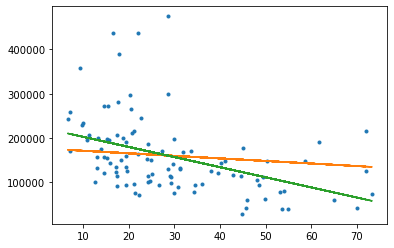

In [13]:
plt.plot(sales_noCC['CrimeRate'], sales_noCC['HousePrice'], '.',
         sales_noCC['CrimeRate'], crime_model.predict(np.array(X_noCC)), '-',
         sales_noCC['CrimeRate'], crime_model_noCC.predict(np.array(X_noCC)), '-')

# Remove high-value outlier neighborhoods and redo analysis

Based on the discussion above, a question is whether the outlying high-value towns are strongly influencing the fit.  Let's remove them and see what happens.

In [14]:
sales_nohighend = sales_noCC[sales_noCC['HousePrice'] < 350000]

X_nohighend = np.array(sales_nohighend['CrimeRate'])
X_nohighend = X_nohighend.reshape(-1,1)
y_nohighend = np.array(sales_nohighend['HousePrice'])

reg_nohighend = LinearRegression()
crime_model_nohighend = reg_nohighend.fit(X_nohighend,y_nohighend)

#crime_model_nohighend = turicreate.linear_regression.create(
#    sales_nohighend,
#    target='HousePrice',
#    features=['CrimeRate'],
#    validation_set=None,
#    verbose=False
#)

### Do the coefficients change much?

In [15]:
reg_noCC.coef_

array([-2288.68942995])

In [16]:
reg_nohighend.coef_

array([-1838.56264859])

Above: We see that removing the outlying high-value neighborhoods has *some* effect on the fit, but not nearly as much as our high-leverage Center City datapoint.

### Compare the two models
Confirm the above calculations by looking at the plots. The orange line is the no high-end model, and the green line is the no-city-center model.

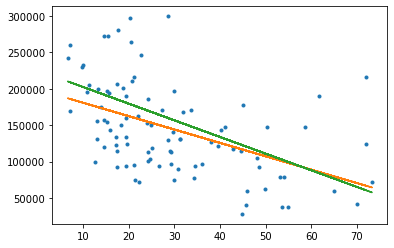

In [17]:
plt.plot(sales_nohighend['CrimeRate'], sales_nohighend['HousePrice'], '.',
         sales_nohighend['CrimeRate'], crime_model_nohighend.predict(np.array(X_nohighend)), '-',
         sales_nohighend['CrimeRate'], crime_model_noCC.predict(np.array(X_nohighend)), '-')         